# IMDB Datasets ETL
__Goal:__ Load relevant IMDB datasets from website and combine them into a single dataset after due preprocessing. The dataset produced by this process is saved in the `10-data` directory.

### Methodological decisions
* Only movies. Keep documentaries.
* Non adult films
* Exclude Reality-TV, Talk-Show and Game-Show

### Methodological questions
* [ ] How to deal with missing values?

### Load packages

In [145]:
#!pip install pqdm

In [146]:
import pandas as pd
import numpy as np
import missingno as mn
from collections import Counter
import requests
#from tqdm import tqdm
#tqdm.pandas()
from pqdm.threads import pqdm
import os

from random import sample

pd.set_option('display.max_rows',100)

print(os.getcwd())

C:\Users\felbu\OneDrive\FGV\movie_success_and_foreign_policy\20-code


In [147]:
from API_key import API_headers, API_url

### Define paths and constants

In [148]:
years = list(range(1980,2023))
print(min(years), max(years))

1980 2022


In [149]:
basics_url = "https://datasets.imdbws.com/title.basics.tsv.gz"
ratings_url = "https://datasets.imdbws.com/title.ratings.tsv.gz"
akas_url = "https://datasets.imdbws.com/title.akas.tsv.gz"

In [150]:
data_dir = "../10-data"

### Define auxiliary functions

In [151]:
def load_imdb_dataset(url, 
                      sep="\t", 
                      encoding="utf-8",
                      index_col="tconst",
                      missing="\\N"):
    
    df = pd.read_csv(url, sep=sep, encoding=encoding, index_col=index_col)
    df[df == missing] = np.nan
    
    print(df.shape, tuple(df.columns))
    return(df)

### ETL

#### basics

In [152]:
#%%time
basics = load_imdb_dataset(basics_url)

C:\Users\felbu\AppData\Local\Temp\ipykernel_24088\4031469021.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=sep, encoding=encoding, index_col=index_col)


(10325176, 8) ('titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres')


In [153]:
# Delete me!
#basics.to_csv('../10-data/basics.csv')

In [154]:
# Delete me!
#basics = pd.read_csv('../10-data/basics.csv', index_col='tconst')
#print(basics.shape, tuple(basics.columns))

In [155]:
basics.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894,NaN,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,NaN,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,NaN,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,0,1892,NaN,12,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,NaN,1,"Comedy,Short"


In [156]:
basics["startYear"] = basics["startYear"].astype("float")
basics["endtYear"] = basics["endYear"].astype("float")

In [157]:
print(basics.shape)

basics = (basics.
          filter(["titleType","primaryTitle","isAdult","startYear","runtimeMinutes","genres"]).
          query("titleType == 'movie'").
          query("isAdult == 0").
          query("startYear.isin(@years)").
          filter(["primaryTitle","startYear","runtimeMinutes","genres"])
         )

print(basics.shape)

(10325176, 9)
(376181, 4)


#### ratings

In [158]:
%%time
ratings = load_imdb_dataset(ratings_url)

(1370302, 2) ('averageRating', 'numVotes')
CPU times: total: 1.27 s
Wall time: 3.73 s


In [159]:
# Delete me!
#ratings.to_csv('../10-data/ratings.csv')

In [160]:
# Delete me!
#ratings = pd.read_csv('../10-data/ratings.csv', index_col='tconst')
#print(ratings.shape, tuple(ratings.columns))

In [161]:
ratings.head()

,averageRating,numVotes
tconst,,
tt0000001,5.7,2007
tt0000002,5.8,269
tt0000003,6.5,1912
tt0000004,5.5,178
tt0000005,6.2,2692


#### merge basics + ratings

In [162]:
print(basics.shape, ratings.shape)

data = pd.merge(basics, ratings, 
                how="inner", 
                left_index=True, right_index=True, 
                validate="1:1", 
                indicator=True)

print(data.shape)

(376181, 4) (1370302, 2)
(213778, 7)


In [163]:
data.head()

,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,_merge
tconst,,,,,,,
tt0013274,Istoriya grazhdanskoy voyny,2021.0,94,Documentary,6.8,59,both
tt0015414,La tierra de los toros,2000.0,60,NaN,5.2,16,both
tt0015724,Dama de noche,1993.0,102,"Drama,Mystery,Romance",6.1,27,both
tt0035423,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,87975,both
tt0036606,"Another Time, Another Place",1983.0,118,"Drama,War",6.5,345,both


In [164]:
data._merge.value_counts(normalize=True)

both          1.0
left_only     0.0
right_only    0.0
Name: _merge, dtype: float64

In [165]:
data = data.drop(columns=["_merge"])

In [166]:
data.head()

,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,
tt0013274,Istoriya grazhdanskoy voyny,2021.0,94,Documentary,6.8,59
tt0015414,La tierra de los toros,2000.0,60,NaN,5.2,16
tt0015724,Dama de noche,1993.0,102,"Drama,Mystery,Romance",6.1,27
tt0035423,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,87975
tt0036606,"Another Time, Another Place",1983.0,118,"Drama,War",6.5,345


#### Movies exibited in the US

In [23]:
%%time
akas = load_imdb_dataset(akas_url, index_col="titleId")

C:\Users\felbu\AppData\Local\Temp\ipykernel_24088\4031469021.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=sep, encoding=encoding, index_col=index_col)


(37730468, 7) ('ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle')
CPU times: total: 1min 14s
Wall time: 2min 45s


In [24]:
shown_in_US = set(akas[akas.region=="US"].index)
movies_shown_in_US = list(set(data.index).intersection(shown_in_US))
del(shown_in_US)
len(movies_shown_in_US)

122877

In [25]:
del akas

#### API

In [26]:
def fetch_movie_API(movie_id, headers=API_headers, url=API_url):
    
    try:
        querystring = {"i": movie_id,"r":"json","type":"movie"}

        response = requests.get(url, headers=headers, params=querystring)
        
        if response.status_code == 200:
            movie_info = response.json()
            return(response.json())
        else:
            print(f"Erro na requisição. Código de status {response.status_code}")
    except Exception as e:
        print(f"Erro na chamada GET: {e}")

In [27]:
#movies_shown_in_US = sample(movies_shown_in_US, 100)
print(len(movies_shown_in_US))

122877


In [28]:
#%%time
#API_results = list(map(fetch_movie_API, movies_shown_in_US))

In [29]:
#API_results = list(pd.Series(movies_shown_in_US).progress_apply(fetch_movie_API))

In [30]:
API_results = list(pqdm(movies_shown_in_US, fetch_movie_API, n_jobs=4))

QUEUEING TASKS | :   0%|          | 0/122877 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/122877 [00:00<?, ?it/s]

Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 522
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520
Erro na requisição. Código de status 520


COLLECTING RESULTS | :   0%|          | 0/122877 [00:00<?, ?it/s]

In [46]:
import pickle

In [47]:
# Save the list to a file
with open('../10-data/API_results.pkl', 'wb') as file:
    pickle.dump(API_results, file)

In [167]:
# Load the list from the file
with open('API_results.pkl', 'rb') as file:
    API_results = pickle.load(file)

In [168]:
len(API_results)

122877

In [169]:
def make_df_from_API_response(list_of_responses, 
                              usecols=["Title",
                                       "Year",
                                       "Rated",
                                       "Runtime",
                                       "Genre",
                                       "Language",
                                       "Country",
                                       "Awards",
                                       "imdbRating",
                                       "Metascore",
                                       "BoxOffice",
                                       "Plot"]):
    
    #Remove None values
    a = len(list_of_responses)
    list_of_responses = [d for d in list_of_responses if d is not None]
    b = len(list_of_responses)
    print(f"{a-b} None values removed")
        
    #Transform list of dicts to df
    df = pd.DataFrame(list_of_responses)
    
    #Define index
    df.set_index('imdbID', inplace=True)
    
    #Select columns
    df = df.loc[:, usecols]
    
    #Identify missing values as such
    df = df.replace("N/A",np.nan)
    
    return(df)

In [170]:
API_df = make_df_from_API_response(API_results)
API_df.head()

23 None values removed


,Title,Year,Rated,Runtime,Genre,Language,Country,Awards,imdbRating,Metascore,BoxOffice,Plot
imdbID,,,,,,,,,,,,
tt0118055,Up Close & Personal,1996,PG-13,124 min,"Drama, Romance","English, Spanish",United States,Nominated for 1 Oscar. 3 wins & 3 nominations ...,6.1,NaN,"$51,088,705","An ambitious young woman, determined to build ..."
tt0498846,Sweet Mud,2006,NaN,90 min,Drama,"Hebrew, French, English","Israel, Germany, France, Japan",9 wins & 7 nominations,7.1,NaN,NaN,"Set in mid-70's, 12-year old Dvir Avni navigat..."
tt0117365,Shadow Play,1996,NaN,111 min,"Comedy, Romance",French,"France, United Kingdom",1 win & 2 nominations,5.8,54,"$16,367","Ada and Lise are both costume designers, the f..."
tt14490618,B.A. Pass 3,2021,NaN,136 min,"Drama, Romance",Hindi,India,NaN,5.2,NaN,NaN,BA Pass 3 narrates the story of a jobless Ansh...
tt5758426,The Forester,1987,NaN,NaN,NaN,Persian,Iran,NaN,NaN,NaN,NaN,NaN


In [171]:
#API_df.to_parquet('../10-data/API_data.parquet')

In [130]:
#API_df = pd.read_parquet('../10-data/API_data.parquet')

In [172]:
print(API_df.shape)

(122854, 12)


In [173]:
#mn.matrix(API_df)

In [174]:
#API_df[["BoxOffice"]].sample(1)

In [175]:
API_df.isna().mean()

Title         0.000033
Year          0.000033
Rated         0.588959
Runtime       0.065509
Genre         0.017712
Language      0.023776
Country       0.007505
Awards        0.551899
imdbRating    0.087820
Metascore     0.858865
BoxOffice     0.859589
Plot          0.059705
dtype: float64

#### Select foreign movies

In [176]:
print(API_df.shape)
API_df = API_df.dropna(subset=['Country'])
API_df = API_df[~API_df['Country'].str.contains(r'United States|US|USA')]
print(API_df.shape)

(122854, 12)
(56059, 12)


In [177]:
API_df.head()

,Title,Year,Rated,Runtime,Genre,Language,Country,Awards,imdbRating,Metascore,BoxOffice,Plot
imdbID,,,,,,,,,,,,
tt0498846,Sweet Mud,2006,NaN,90 min,Drama,"Hebrew, French, English","Israel, Germany, France, Japan",9 wins & 7 nominations,7.1,NaN,NaN,"Set in mid-70's, 12-year old Dvir Avni navigat..."
tt0117365,Shadow Play,1996,NaN,111 min,"Comedy, Romance",French,"France, United Kingdom",1 win & 2 nominations,5.8,54,"$16,367","Ada and Lise are both costume designers, the f..."
tt14490618,B.A. Pass 3,2021,NaN,136 min,"Drama, Romance",Hindi,India,NaN,5.2,NaN,NaN,BA Pass 3 narrates the story of a jobless Ansh...
tt5758426,The Forester,1987,NaN,NaN,NaN,Persian,Iran,NaN,NaN,NaN,NaN,NaN
tt5808796,Meat,2017,NaN,76 min,Documentary,English,New Zealand,NaN,6.5,NaN,NaN,Different perspectives tell a modern story of ...


#### Merge API response with data

In [178]:
print(data.shape, API_df.shape)

data_ = data.copy()
data = pd.merge(API_df,data_, 
                how="inner", 
                left_index=True, right_index=True, 
                validate="1:1", 
                indicator=True)

print(data.shape)

(213778, 6) (56059, 12)
(56053, 19)


In [179]:
data.drop(columns=["_merge","startYear","Genre","Runtime","primaryTitle"], inplace=True)

In [180]:
data.head()

,Title,Year,Rated,Language,Country,Awards,imdbRating,Metascore,BoxOffice,Plot,runtimeMinutes,genres,averageRating,numVotes
tt0498846,Sweet Mud,2006,NaN,"Hebrew, French, English","Israel, Germany, France, Japan",9 wins & 7 nominations,7.1,NaN,NaN,"Set in mid-70's, 12-year old Dvir Avni navigat...",90,Drama,7.1,762
tt0117365,Shadow Play,1996,NaN,French,"France, United Kingdom",1 win & 2 nominations,5.8,54,"$16,367","Ada and Lise are both costume designers, the f...",111,"Comedy,Romance",5.8,495
tt14490618,B.A. Pass 3,2021,NaN,Hindi,India,NaN,5.2,NaN,NaN,BA Pass 3 narrates the story of a jobless Ansh...,136,"Drama,Romance",5.2,3035
tt5758426,The Forester,1987,NaN,Persian,Iran,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,11
tt5808796,Meat,2017,NaN,English,New Zealand,NaN,6.5,NaN,NaN,Different perspectives tell a modern story of ...,76,Documentary,6.7,32


In [181]:
data["Year"] = data["Year"].astype("int")
data["imdbRating"] = data["imdbRating"].astype("float")
data["Metascore"] = data["Metascore"].astype("float")
data["runtimeMinutes"] = data["runtimeMinutes"].astype("float")
data.dtypes

Title              object
Year                int32
Rated              object
Language           object
Country            object
Awards             object
imdbRating        float64
Metascore         float64
BoxOffice          object
Plot               object
runtimeMinutes    float64
genres             object
averageRating     float64
numVotes            int64
dtype: object

In [191]:
data.to_parquet('../10-data/IMDB_data_final.parquet')

<Axes: >

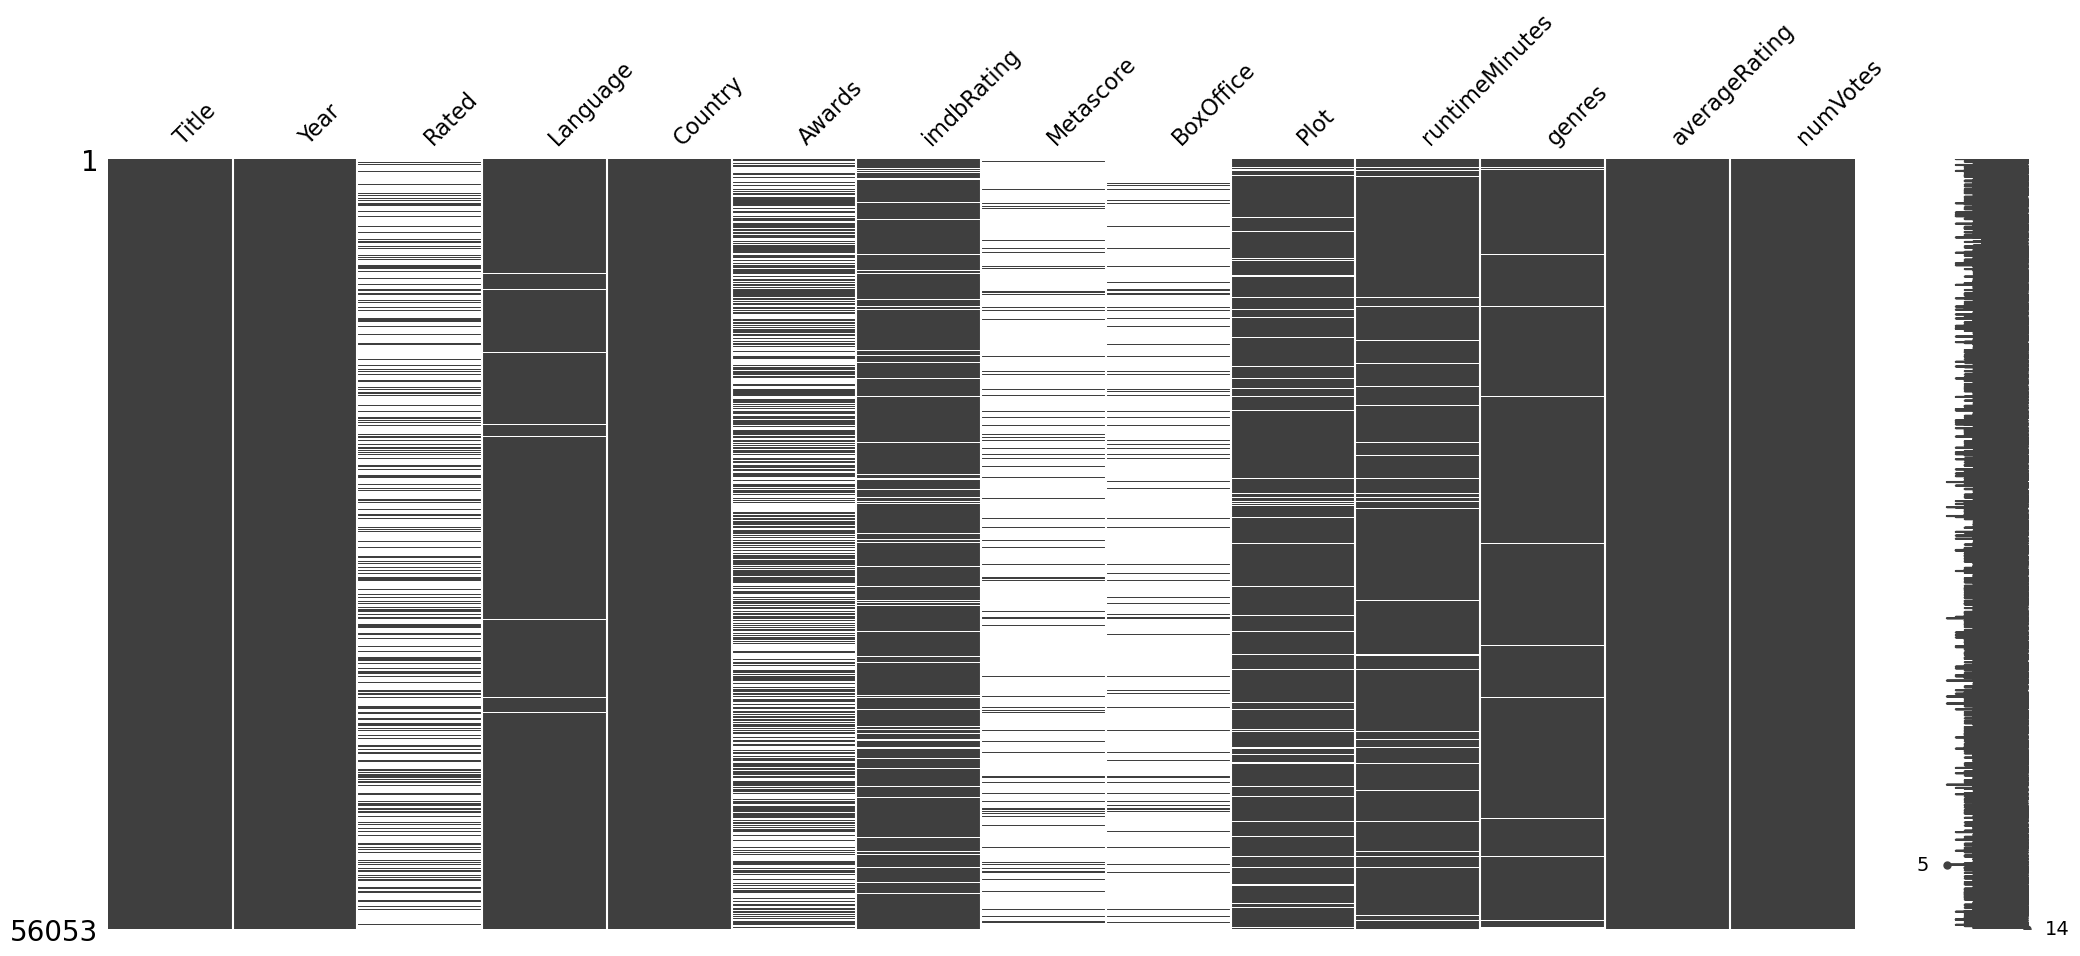

In [182]:
mn.matrix(data)

In [183]:
1-data.isna().mean().sort_values(ascending=False)

Metascore         0.083849
BoxOffice         0.086026
Rated             0.278362
Awards            0.546964
imdbRating        0.920361
Plot              0.935097
runtimeMinutes    0.961947
Language          0.985050
genres            0.987976
Title             1.000000
Year              1.000000
Country           1.000000
averageRating     1.000000
numVotes          1.000000
dtype: float64

In [184]:
data_with_BoxOffice = data[~data.BoxOffice.isna()]
data_with_BoxOffice.shape[0]

4822

In [185]:
data_with_BoxOffice.to_excel("../10-data/dataset_with_BoxOffice.xlsx")

In [186]:
data_with_BoxOffice.describe().to_excel("../10-data/dataset_with_BoxOffice.xlsx")

## Profile report

In [187]:
from ydata_profiling import ProfileReport

In [188]:
profile_data = data
profile_desc = "IMDB_full_data"
print(profile_data.shape[0])

56053


In [189]:
profile = ProfileReport(profile_data, title=profile_desc)

In [190]:
profile.to_file(profile_desc +".html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]